# Experiment with the MNIST data set

In [1]:
from aitk.utils import gallery, array_to_image
from aitk.networks import Network

import tensorflow
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.utils import to_categorical

# Get the data
* Download the data
* Explore what you have

In [2]:
(train_x, train_y), (test_x, test_y) = mnist.load_data()

In [3]:
train_x.shape

(60000, 28, 28)

In [4]:
test_x.shape

(10000, 28, 28)

In [5]:
images = [array_to_image(train_x[i]) for i in range(20)]

In [6]:
gallery(images)

0,1,2,3,4
5,6,7,8,9
10,11,12,13,14
15,16,17,18,19


In [7]:
train_y[:20]

array([5, 0, 4, 1, 9, 2, 1, 3, 1, 4, 3, 5, 3, 6, 1, 7, 2, 8, 6, 9],
      dtype=uint8)

# Prepare the data for the network
* You may need to normalize the inputs so that they are in the range [0,1].
* You may need to convert the targets so that they are represented as one-hot vectors when you are doing categorization.

### Input data

In [8]:
min_input = train_x.min()
max_input = train_x.max()
print("range of input values is:", min_input, max_input)

range of input values is: 0 255


In [9]:
train_x_normalized = (train_x - min_input) / float(max_input-min_input)

In [10]:
test_x_normalized = (test_x - min_input) / float(max_input-min_input)

### Data sent into a Conv2D layer must have a depth
* This may require you to do a reshape command.
* For these black and white images there is only one channel of information.
* For color images there are typically 3 channels (Red, Green, Blue)

In [11]:
train_x_normalized = train_x_normalized.reshape(60000,28,28,1)
test_x_normalized = test_x_normalized.reshape(10000,28,28,1)

### Target data

In [12]:
num_categories = len(set(train_y))

In [13]:
train_y_category = to_categorical(train_y, num_categories)

In [14]:
test_y_category = to_categorical(test_y, num_categories)

In [15]:
train_y_category[0]

array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.], dtype=float32)

# Construct the model

This is just one possible configuration of layers to learn the MNIST data set.  Feel free to experiment with the number of filters, the filter size, and the layers themselves.

In [16]:
neural_net = Sequential()
neural_net.add(Conv2D(8,(5,5),activation="relu",input_shape=(28,28,1)))
neural_net.add(MaxPooling2D(pool_size=(2,2)))
neural_net.add(Flatten())
neural_net.add(Dense(100, activation='relu'))
neural_net.add(Dense(10, activation='softmax'))
neural_net.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 24, 24, 8)         208       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 8)         0         
_________________________________________________________________
flatten (Flatten)            (None, 1152)              0         
_________________________________________________________________
dense (Dense)                (None, 100)               115300    
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1010      
Total params: 116,518
Trainable params: 116,518
Non-trainable params: 0
_________________________________________________________________


# Compile the model

For our XOR networks we defined loss as sum-squared error.  However, for categorical data like handwritten digits it is better to use a different loss function called *categorical_crossentropy*.  This interprets the outputs as representing probabilities and forces them to sum to 1.0.  Thus the output from the network will reflect how likely it considers a particular input to be a member of one of the output categories.

In [17]:
neural_net.compile(optimizer="SGD", loss="categorical_crossentropy",
                   metrics=['accuracy'])

# Create an aitk Network
This allows us to do more visualization of what is happening inside the network.

In [18]:
net = Network(neural_net)

In [19]:
from time import sleep
for i in range(10):
    net.propagate(train_x_normalized[i])
    net.display(train_x_normalized[i])
    sleep(1.0)

# Train the model

In [20]:
history = net.fit(train_x_normalized, 
                  train_y_category, 
                  verbose=1,
                  validation_data=(test_x_normalized, 
                                   test_y_category),
                  epochs=5)

Epoch 5/5 loss: 0.11030992120504379 - accuracy: 0.96670001745224 - val_loss: 0.09778580069541931 - val_accuracy: 0.9696999788284302


# Inspect the feature maps

We can ask the network to propagate to specific layers and inspect the representations created there to try to understand how it has solved the problem.

channel0,channel1,channel2,channel3,channel4,channel5,channel6,channel7

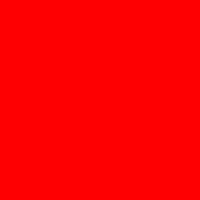
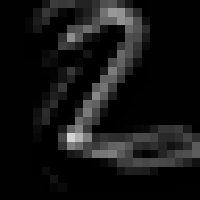
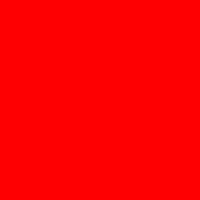
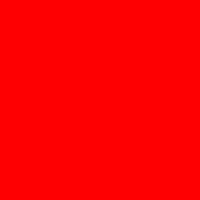
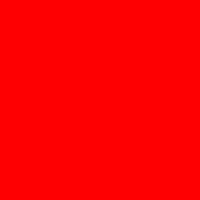
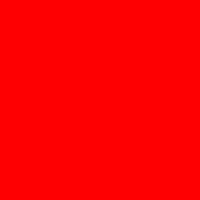
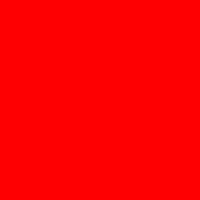
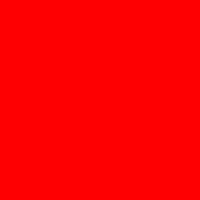

In [21]:
images = [net.propagate_to(test_x_normalized[1], "conv2d", "image", channel=channel)
         for channel in range(8)]
bigger = [image.resize((200,200),resample=0) for image in images]
gallery(bigger, labels="channel{index}", gallery_shape=(8,1))

channel0,channel1,channel2,channel3,channel4,channel5,channel6,channel7

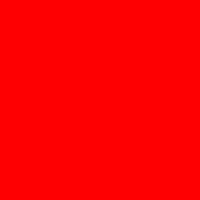
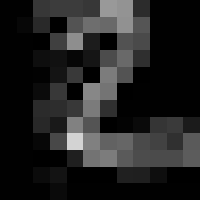
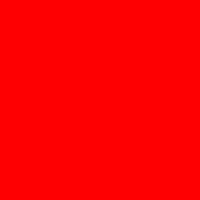
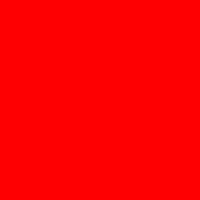
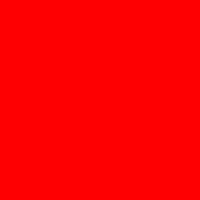
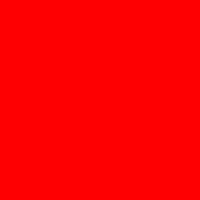
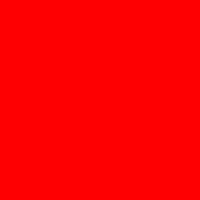
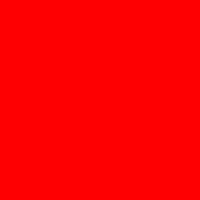

In [22]:
images = [net.propagate_to(test_x_normalized[1], "max_pooling2d", "image", channel=channel)
         for channel in range(8)]
bigger = [image.resize((200,200),resample=0) for image in images]
gallery(bigger, labels="channel{index}", gallery_shape=(8,1))

# Examine the results
Check which inputs the network is getting wrong. Recall that there are 10 thousand test images.

In [23]:
from numpy import argmax
outputs = net.predict(test_x_normalized)
answers = [argmax(output) for output in outputs]
targets = [argmax(target) for target in test_y_category]

In [24]:
incorrect = [i for i in range(len(answers)) if answers[i] != targets[i]]
wrong_ans = [answers[i] for i in incorrect]
len(incorrect)

303

In [25]:
images = [array_to_image(test_x[index]) for index in incorrect]
gallery(images, labels=wrong_ans)

6,8,2,0,7,3,0,0,8,8,0,2,7,3,8,8,9,8
3,4,9,9,6,6,0,5,1,8,7,3,6,8,8,7,2,4
9,0,6,7,3,6,2,6,8,2,6,3,4,4,0,1,9,6
7,2,8,9,6,6,3,0,7,3,0,3,8,7,3,4,0,0
3,2,7,9,4,8,7,9,4,0,8,0,9,1,5,2,5,3
1,8,6,0,6,7,9,1,3,3,1,4,7,1,0,8,4,1
8,0,1,8,3,3,3,4,0,2,7,9,5,8,8,7,2,6
9,3,3,3,9,7,8,3,9,0,1,4,8,0,3,3,3,9
4,8,3,2,9,6,8,3,3,5,3,4,6,3,3,3,2,4
4,5,2,3,0,3,4,3,2,0,7,9,6,5,7,8,3,7
7,9,6,4,7,6,7,5,6,9,4,9,3,0,5,4,3,0
